In [35]:
import torch
import sys
import openslide
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import ceil
from util import format_output, output2annotations
from collections import OrderedDict

sys.path.insert(1, '/home/rens/repos/hover_net')
from models.hovernet.net_desc import HoVerNet

class Inspector():
    def __init__(self, slide_path, ground_truth_path=None, pixel_width=0.2485, pixel_height=0.2485):
        self.slide = openslide.OpenSlide(slide_path)
        if ground_truth_path is not None:
            self.ground_truth = np.array(Image.open(ground_truth_path))
        else:
            self.ground_truth = None


        self.pixel_width = pixel_width
        self.pixel_height = pixel_height

        self.patch = None
        
        self.net = HoVerNet(nr_types=6,mode='fast')
        ckpt = torch.load('/home/rens/repos/premium_pathology/weights/hovernet_fast_pannuke_type_tf2pytorch.tar')
        self.net.load_state_dict(ckpt['desc'], strict=True)
        self.net.eval()
        self.net.to('cuda')

    def display(self):
        slide_image = np.array(self.slide.read_region(
            (0,0), 
            3, 
            self.slide.level_dimensions[3]).convert('RGB')
        )
        fig, ax = plt.subplots(1,2,figsize=(24,12))
        ax[0].imshow(slide_image)
        if self.ground_truth is not None:
            ax[1].imshow(self.ground_truth)
        fig.show()

        print(self.slide.level_dimensions[0])

    def extract_patch(self):
        size_x = ceil((self.xmax-self.xmin) / 164) * 164 + 92
        size_y = ceil((self.ymax-self.ymin) / 164) * 164 + 92

        patch = np.array(self.slide.read_region(
            (self.xmin-46,self.ymin-46), 0, (size_x,size_y)
        ))

        return patch  

    def select_patch(self, xmin, xmax, ymin, ymax):
        self.xmin, self.xmax = (np.array([xmin, xmax]) / self.pixel_width).astype(int)
        self.ymin, self.ymax = (np.array([ymin, ymax]) / self.pixel_height).astype(int)

        self.patch = self.extract_patch()

        slide_image = np.array(self.slide.read_region(
            (0,0), 
            3, 
            self.slide.level_dimensions[3]).convert('RGB')
        )
        
        fig, ax = plt.subplots(1,2,figsize=(24,12))
        ax[0].imshow(slide_image)
        ax[0].plot(
            (np.array([self.xmin,self.xmax,self.xmax,self.xmin,self.xmin]) / 32).astype(int),
            (np.array([self.ymin,self.ymin,self.ymax,self.ymax,self.ymin]) / 32).astype(int),
            color='red'
        )
        ax[1].imshow(self.patch)
        ax[1].plot(
            [46,46+self.xmax-self.xmin,46+self.xmax-self.xmin,46,46],
            [46,46,46+self.ymax-self.ymin,46+self.ymax-self.ymin,46],
            c='red'
        )
        fig.show()

    def infer(self):
        if self.patch is None:
            print('No patch selected yet')
            return

        batch = self.tilefy()
        batch = batch.to('cuda:0')
        self.net.to('cuda:0')

        batch_size = 16
        required_batches = ceil(batch.shape[0] / batch_size)

        chunk_results = []
        for ix in range(required_batches):
            chunk = batch[ix*batch_size:(ix+1)*batch_size]
            chunk = chunk.to('cuda')
            with torch.no_grad():
                out = inspector.net(chunk)
            chunk = chunk.to('cpu')

            for k in out.keys():
                out[k] = out[k].to('cpu')

            torch.cuda.empty_cache()

            chunk_results.append(out)

        merged = OrderedDict({
            'tp':torch.cat([chunk['tp'] for chunk in chunk_results]),
            'np':torch.cat([chunk['np'] for chunk in chunk_results]),
            'hv':torch.cat([chunk['hv'] for chunk in chunk_results]),
        })

        formatted_output = format_output(merged)
        annotation = [output2annotations(pred) for pred in formatted_output]

        self.display_prediction(annotation)

    def tilefy(self):
        xx = np.arange(0,self.patch.shape[0], 164)[:-1]
        yy = np.arange(0,self.patch.shape[1], 164)[:-1]

        self.origins = np.array([(x,y) for y in yy for x in xx])

        tiles = []
        for x, y in self.origins:
                tiles.append(self.patch[x:x+256, y:y+256])

        batch = torch.tensor(np.stack(tiles)[...,:-1].transpose(0,3,1,2))
        
        return batch

    def display_prediction(self, annotation):
        type2color = {
            0:'gray',
            1:'b',
            2:'r',
            3:'gray',
            4:'gray',
            5:'g'
        }

        fig, ax = plt.subplots(1,2,figsize=(36,18))
        ax[0].imshow(self.patch)
        for origin, inst_info_dict in zip(self.origins, annotation):
            for inst in inst_info_dict.values():
                xx, yy = np.split(inst['contour'] \
                    + np.flip(origin,axis=0) \
                    + np.array([46,46]), 2, axis=-1)
                ax[0].plot(xx, yy, linestyle='--', lw=3, c=type2color[inst['type']])
        ax[1].imshow(self.patch)
        fig.show()

In [49]:
inspector = Inspector(
    '/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/PREM-IS-009_412623daa8 II30 HE1 - 2022-03-24 19.19.23.ndpi',
    # '/data/data/pathology/tcga/TIL_maps_after_thres_v1/skcm/TCGA-3N-A9WC-01Z-00-DX1.png',
    pixel_width=0.2298,
    pixel_height=0.2299
)

(126720, 94464)


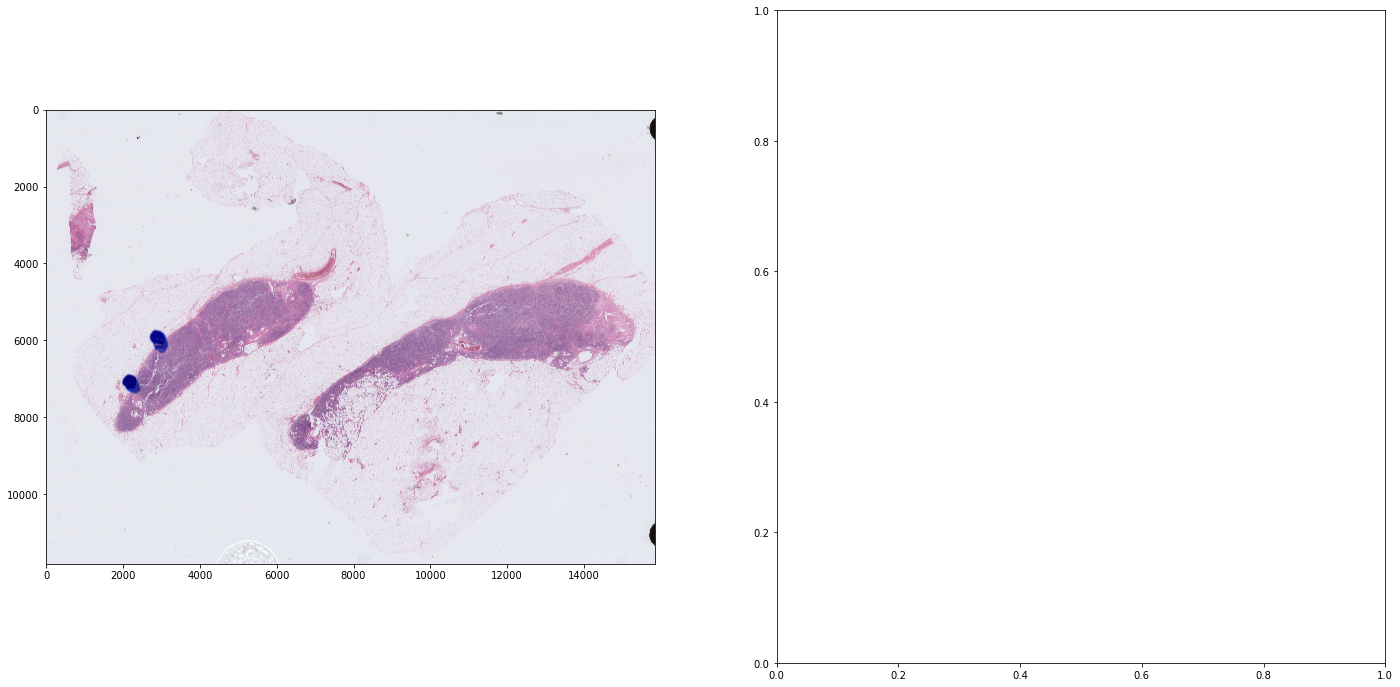

In [50]:
inspector.display()

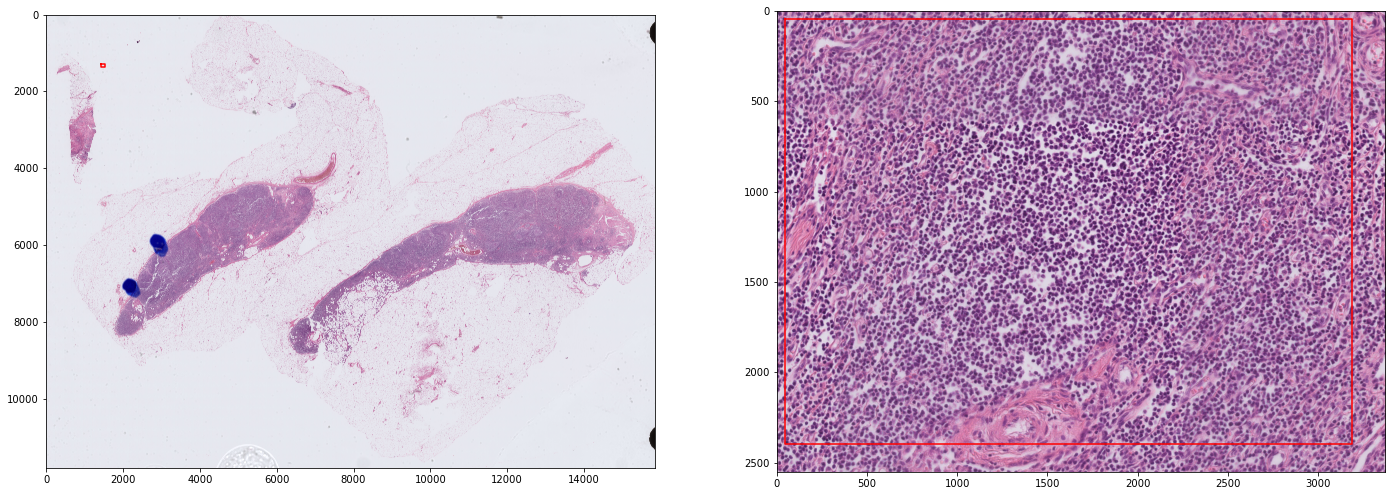

In [51]:
inspector.select_patch(10525,11247,9407,9947)

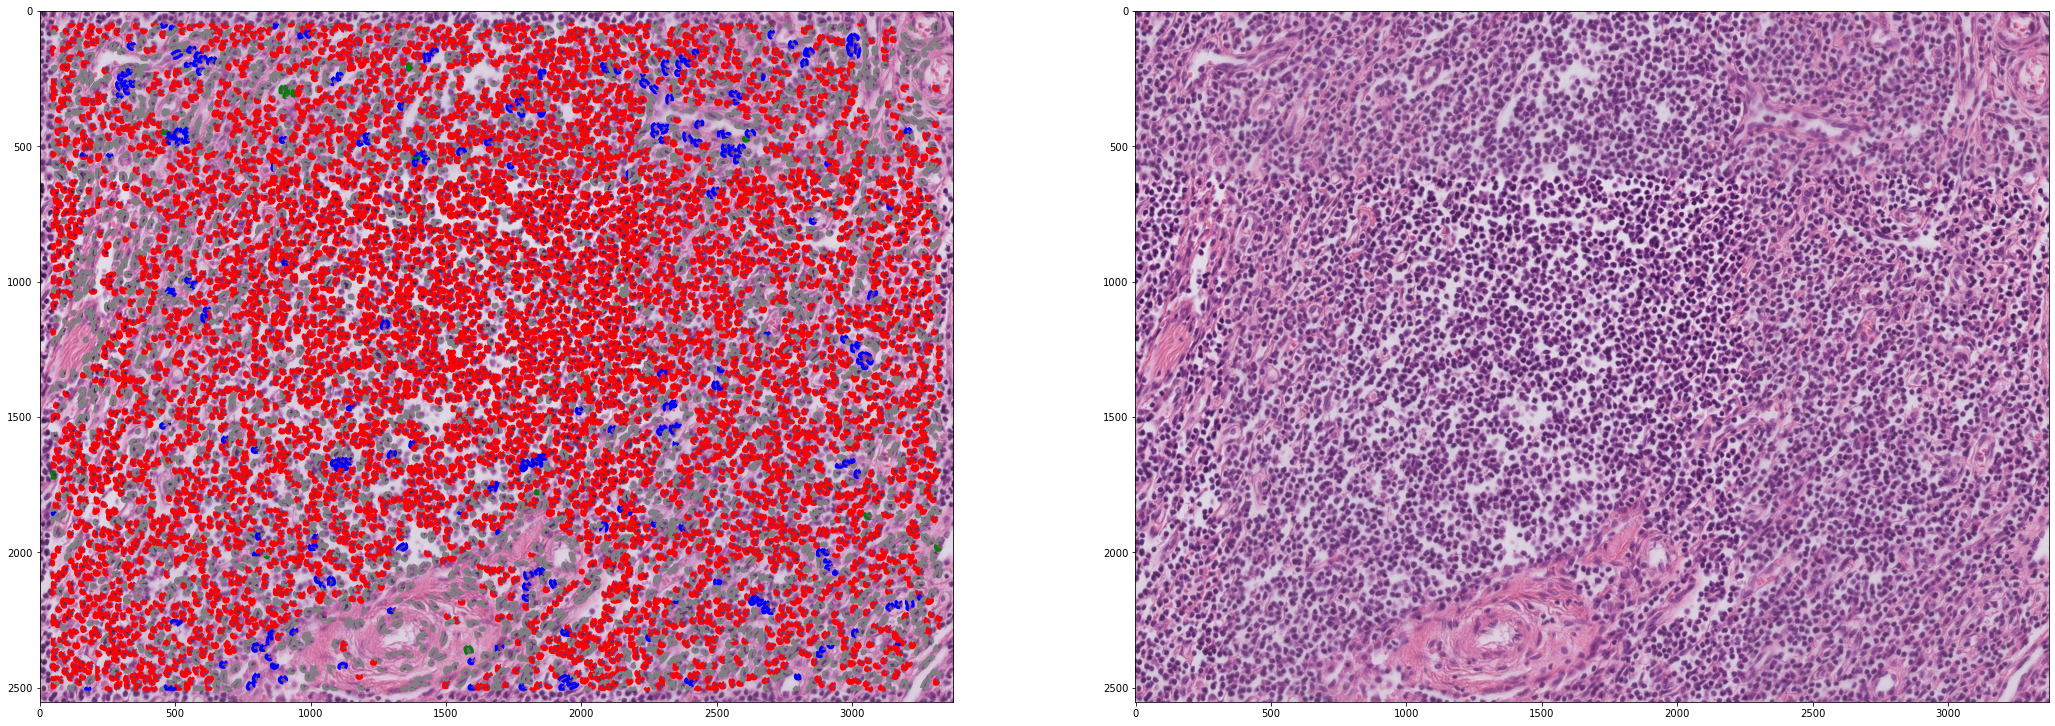

In [52]:
inspector.infer()

In [14]:
from collections import OrderedDict

merged = OrderedDict({
    'tp':torch.cat([chunk['tp'] for chunk in chunk_results]),
    'np':torch.cat([chunk['np'] for chunk in chunk_results]),
    'hv':torch.cat([chunk['hv'] for chunk in chunk_results]),
})

In [12]:
chunk_results[0].keys()

odict_keys(['tp', 'np', 'hv'])

In [8]:
chunk = chunk.to('cpu')

In [19]:
out['hv'] = out['hv'].to('cpu') 

In [10]:
torch.cuda.empty_cache()